In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
import math
import operator

from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
import matplotlib as mpl
import statistics
import seaborn as sns

import pytz
import us
import datetime as dt

In [4]:
import sqlalchemy
import psycopg2
import simplejson
import os
%load_ext sql
 
%config SqlMagic.displaylimit = 50

with open(os.path.join(os.path.expanduser('~'), ".redshift-creds.json")) as fh:
    creds = simplejson.loads(fh.read())
    
connect_to_db = 'postgresql+psycopg2://' + \
                creds['user_name'] + ':' + creds['password'] + '@' + \
                '127.0.0.1' + ':' + creds['port_num'] + '/' + creds['db_name'];
%sql $connect_to_db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


'Connected: giridhar@dw01'

In [5]:
tempDf = %sql SELECT activity.user_id as user_id, activity_start, activity_end, cardtype, autocreated, demographics.gender, demographics.city, demographics.name as state_name, demographics.state_id as state_id, demographics.birthdate, demographics.weight, demographics.height, demographics.dailygoal, demographics.age FROM (SELECT user_id, utcstart as activity_start, utcend as activity_end, cardtype, autocreated FROM parse.activitystorageentryparse WHERE activity_start>'2017-11-01 00:00:00' ORDER BY activity_start) activity JOIN (SELECT x.user_id, y.name, x.city, x.state_id, x.gender, x.birthdate, x.weight, x.height, x.dailygoal, x.age FROM (SELECT d.user_id, d.email, d.gender, c.city, c.state_id, d.birthdate, d.weight, d.height, d.dailygoal, d.age FROM (ecomm_prod.orders a JOIN ecomm_prod.addresses b ON a.id = b.id) c JOIN (select distinct pu.id as user_id, pup.gender, pup.birthdate, pup.weight, pup.height, pup.dailygoal, pup.age, pu.email from parse.user pu join parse.userprofile pup on pu.id = pup.user_id) d on c.email =  d.email) x  JOIN ecomm_prod.states y ON x.state_id = y.id) demographics on activity.user_id = demographics.user_id

2560575 rows affected.


In [6]:
actDf = pd.DataFrame(tempDf)

In [36]:
actDf.columns = ['dummy','user_id','activity_start','activity_end','cardtype','autocreated','gender','city','state_name','state_id','birthdate','weight','height']
actDf = actDf[pd.notnull(actDf['gender'])]
actDf['activity_start'] = pd.to_datetime(actDf['activity_start'])
actDf['activity_end'] = pd.to_datetime(actDf['activity_end'])
actDf['birthdate'] = pd.to_datetime(actDf['birthdate'])
actDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2538658 entries, 0 to 2538657
Data columns (total 13 columns):
dummy             int64
user_id           object
activity_start    datetime64[ns]
activity_end      datetime64[ns]
cardtype          int64
autocreated       bool
gender            object
city              object
state_name        object
state_id          int64
birthdate         datetime64[ns]
weight            int64
height            int64
dtypes: bool(1), datetime64[ns](3), int64(5), object(4)
memory usage: 254.2+ MB


In [13]:
tempDf_bpm = %sql SELECT bpm.user_id as user_id, epoch_start_utc, BPM, epoch_start_date, epoch_next_utc, demographics.gender, demographics.city, demographics.name as state_name, demographics.birthdate FROM (SELECT PARSE_USER_ID as user_id, UTC_START_TIME_EPOCH  as epoch_start_utc, BPM, UTC_START_AT  as epoch_start_date, NEXT_UTC_START_TIME_EPOCH as epoch_next_utc FROM rawsync.t34_bpm WHERE UTC_START_DATE >'2017-11-01 00:00:00' ORDER BY UTC_START_TIME_EPOCH ) bpm JOIN (SELECT x.user_id, y.name, x.city, x.state_id, x.gender, x.birthdate, x.weight, x.height, x.dailygoal, x.age FROM (SELECT d.user_id, d.email, d.gender, c.city, c.state_id, d.birthdate, d.weight, d.height, d.dailygoal, d.age FROM (ecomm_prod.orders a JOIN ecomm_prod.addresses b ON a.id = b.id) c JOIN (select distinct pu.id as user_id, pup.gender, pup.birthdate, pup.weight, pup.height, pup.dailygoal, pup.age, pu.email from parse.user pu join parse.userprofile pup on pu.id = pup.user_id) d on c.email =  d.email) x  JOIN ecomm_prod.states y ON x.state_id = y.id) demographics on bpm.user_id = demographics.user_id

53047118 rows affected.


In [ ]:
bpmDf = pd.DataFrame(tempDf_bpm)

In [16]:
bpmDf.columns = ['user_id','epoch_start_utc','bpm','epoch_start_date','epoch_next_utc','gender','city','state','birthdate']  
bpmDf['epoch_start_date'] = pd.to_datetime(bpmDf['epoch_start_date'])
bpmDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53047118 entries, 0 to 53047117
Data columns (total 9 columns):
user_id             object
epoch_start_utc     int64
bpm                 int64
epoch_start_date    datetime64[ns]
epoch_next_utc      float64
gender              object
city                object
state               object
birthdate           datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 3.6+ GB


In [20]:
actDf.to_csv('/Users/adgiridhar/Google Drive/PR stories/age/act_2018_04_16.csv')
bpmDf.to_csv('/Users/adgiridhar/Google Drive/PR stories/age/bpm_2018_04_16.csv')

In [38]:
def age_func(row_):
    return ((pd.Timestamp('today')-pd.Timestamp(row_)).days)/365
actDf['age'] = actDf['birthdate'].apply(lambda row: age_func(row))
actDf

dummy     user_id      activity_start        activity_end  \
0              0  0KKQWun76a 2017-12-22 06:00:00 2017-12-22 06:00:00   
1              1  0KKQWun76a 2018-03-23 20:41:00 2018-03-23 21:09:00   
2              2  0KKQWun76a 2017-11-29 19:40:00 2017-11-29 20:09:00   
3              3  0KKQWun76a 2018-04-03 05:00:00 2018-04-03 05:00:00   
4              4  0KKQWun76a 2018-03-24 17:17:00 2018-03-24 17:27:00   
5              5  0KKQWun76a 2017-12-14 06:00:00 2017-12-14 06:00:00   
6              6  0KKQWun76a 2018-03-18 16:13:00 2018-03-18 18:44:00   
7              7  0KKQWun76a 2017-12-15 06:00:00 2017-12-15 06:00:00   
8              8  0KKQWun76a 2018-03-23 15:37:00 2018-03-23 16:33:00   
9              9  0KKQWun76a 2018-04-06 04:47:00 2018-04-06 05:01:00   
10            10  0KKQWun76a 2017-11-22 06:00:00 2017-11-22 06:00:00   
11            11  0KKQWun76a 2017-11-29 06:00:00 2017-11-29 06:00:00   
12            12  0KKQWun76a 2017-11-28 05:28:46 2017-11-28 13:21:40   
13            13  0KKQWun76a 2017-12-16 06:00:00 2017-12-16 06:00:00   
14            14  0KKQWun76a 2017-11-13 22:18:00 2017-11-13 22:45:00   
15            15  0KKQWun76a 2018-02-28 12:24:00 2018-02-28 12:59:00   
16            16  0KKQWun76a 2018-03-19 05:00:00 2018-03-19 05:00:00   
17            17  0KKQWun76a 2017-11-17 05:22:48 2017-11-17 13:17:16   
18            18  0KKQWun76a 2018-03-21 14:58:00 2018-03-21 15:49:00   
19            19  0KKQWun76a 2017-11-07 01:38:00 2017-11-07 02:08:00   
20            20  0KKQWun76a 2018-03-21 05:00:00 2018-03-21 05:00:00   
21            21  0KKQWun76a 2017-11-02 05:10:15 2017-11-02 12:12:37   
22            22  0KKQWun76a 2018-03-01 04:36:07 2018-03-01 12:00:29   
23            23  0KKQWun76a 2017-12-02 23:29:26 2017-12-03 00:17:28   
24            24  0KKQWun76a 2018-01-01 06:03:35 2018-01-01 14:51:02   
25            25  0KKQWun76a 2017-11-05 05:40:06 2017-11-05 12:53:26   
26            26  0KKQWun76a 2018-03-20 02:08:00 2018-03-20 02:19:00   
27            27  0KKQWun76a 2017-12-07 06:00:00 2017-12-07 06:00:00   
28            28  0KKQWun76a 2017-12-17 06:29:53 2017-12-17 13:34:15   
29            29  0KKQWun76a 2017-11-25 18:54:00 2017-11-25 19:58:00   
...          ...         ...                 ...                 ...   
2538628  2560545  zo85RkbTaI 2017-12-13 08:00:00 2017-12-13 08:00:00   
2538629  2560546  zo85RkbTaI 2018-02-17 21:03:00 2018-02-17 21:27:00   
2538630  2560547  zo85RkbTaI 2018-01-29 08:00:36 2018-01-29 08:28:43   
2538631  2560548  zo85RkbTaI 2018-01-17 08:00:00 2018-01-17 08:00:00   
2538632  2560549  zo85RkbTaI 2018-01-05 08:00:00 2018-01-05 08:00:00   
2538633  2560550  zo85RkbTaI 2017-12-17 18:07:00 2017-12-17 18:45:00   
2538634  2560551  zo85RkbTaI 2018-02-03 04:33:49 2018-02-03 17:03:30   
2538635  2560552  zo85RkbTaI 2018-02-10 00:00:00 2018-02-10 00:37:00   
2538636  2560553  zo85RkbTaI 2017-12-17 07:18:06 2017-12-17 14:45:28   
2538637  2560554  zo85RkbTaI 2017-12-08 08:00:00 2017-12-08 08:00:00   
2538638  2560555  zo85RkbTaI 2017-12-12 20:11:00 2017-12-12 20:50:00   
2538639  2560556  zo85RkbTaI 2017-12-23 05:08:15 2017-12-23 11:43:09   
2538640  2560557  zo85RkbTaI 2018-01-11 06:04:10 2018-01-11 15:44:38   
2538641  2560558  zo85RkbTaI 2018-01-28 08:00:00 2018-01-28 08:00:00   
2538642  2560559  zo85RkbTaI 2018-01-18 09:06:21 2018-01-18 09:33:00   
2538643  2560560  zo85RkbTaI 2018-01-24 08:00:00 2018-01-24 08:00:00   
2538644  2560561  zo85RkbTaI 2018-01-16 19:21:00 2018-01-16 19:49:00   
2538645  2560562  zo85RkbTaI 2018-01-12 22:59:00 2018-01-13 00:11:00   
2538646  2560563  zo85RkbTaI 2017-12-12 06:35:01 2017-12-12 15:23:29   
2538647  2560564  zo85RkbTaI 2017-12-28 08:00:00 2017-12-28 08:00:00   
2538648  2560565  zo85RkbTaI 2017-12-16 08:51:00 2017-12-16 18:37:30   
2538649  2560566  zo85RkbTaI 2017-12-02 08:00:00 2017-12-02 08:00:00   
2538650  2560567  zo85RkbTaI 2018-01-14 23:39:00 2018-01-15 00:50:00   
2538651  2560568  zo85RkbTaI 2018-02-07 08:38:00 20

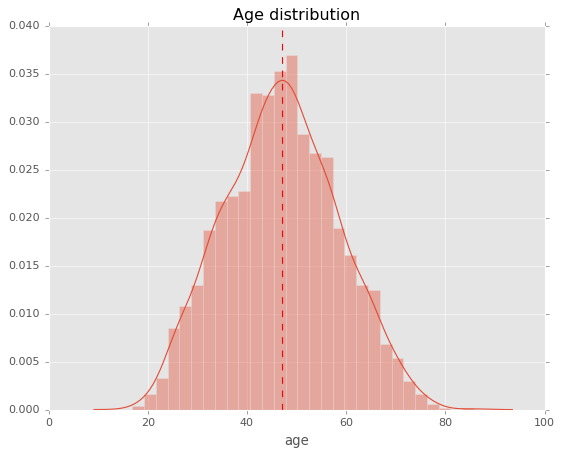

In [104]:
plt.figure()
tempDf = actDf[actDf['user_id'].isin(commUsers)].drop_duplicates(['user_id'])
ax = sns.distplot(tempDf['age'])
data_x, data_y = ax.lines[0].get_data()
plt.axvline(data_x[np.argmax(data_y)],color='r',linestyle='--')
plt.title('Age distribution')
plt.show()

In [87]:
age1 = 35
age2 = 55
print(sum(tempDf['age']<age1),
sum(np.logical_and(tempDf['age']>=age1, tempDf['age']<=age2)),
sum(tempDf['age']>age2))

630 2162 818


1803 1807


In [105]:
print(tempDf['age'].quantile(0.33333),tempDf['age'].quantile(0.666666))

41.94234136986301 51.73148197260274


In [37]:
stepsUsers = stepsDf['user_id'].unique()
#3610
actDf[actDf.index.isin(stepsUsers,level=0)]['age']

In [34]:
stepsDf = pd.read_csv('/Users/adgiridhar/Google Drive/PR stories/age/Total_steps with demographic data_2018_04_16.csv')   
stepsDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153315 entries, 0 to 153314
Data columns (total 12 columns):
user_id       153315 non-null object
tot_steps     153315 non-null int64
gender        151186 non-null object
step_date     153315 non-null object
city          153315 non-null object
state_name    153315 non-null object
state_id      153315 non-null int64
birthdate     151186 non-null object
weight        153315 non-null int64
height        153315 non-null int64
dailygoal     56 non-null float64
age           6 non-null float64
dtypes: float64(2), int64(4), object(6)
memory usage: 14.0+ MB


In [5]:
stepsDf = pd.read_csv('/Users/adgiridhar/Google Drive/PR stories/age/Total_steps with demographic data_2018_04_16.csv')
actDf = pd.read_csv('/Users/adgiridhar/Google Drive/PR stories/age/act_2018_04_16.csv')
bpmDf = pd.read_csv('/Users/adgiridhar/Google Drive/PR stories/age/bpm_2018_04_16.csv')

In [6]:
acti_data = %sql SELECT acti.user_id as user_id, utc_start_at, thresh_data0, thresh_data1, device_serial_number, window_sum, app_trigger, demographics.gender, demographics.city, demographics.name as state_name, demographics.birthdate FROM (select parse_user_id as user_id, utc_start_at, thresh_data0, thresh_data1, device_serial_number, window_sum, app_trigger from rawsync.t40_actigraphy WHERE UTC_START_DATE >'2018-02-03 00:00:00' and UTC_START_DATE <'2018-04-30 00:00:00') acti JOIN (SELECT x.user_id, y.name, x.city, x.state_id, x.gender, x.birthdate, x.weight, x.height, x.dailygoal, x.age FROM (SELECT d.user_id, d.email, d.gender, c.city, c.state_id, d.birthdate, d.weight, d.height, d.dailygoal, d.age FROM (ecomm_prod.orders a JOIN ecomm_prod.addresses b ON a.id = b.id) c JOIN (select distinct pu.id as user_id, pup.gender, pup.birthdate, pup.weight, pup.height, pup.dailygoal, pup.age, pu.email from parse.user pu join parse.userprofile pup on pu.id = pup.user_id) d on c.email =  d.email) x  JOIN ecomm_prod.states y ON x.state_id = y.id) demographics on acti.user_id = demographics.user_id

56765898 rows affected.


In [14]:
actiDf = pd.DataFrame(acti_data)
actiDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56765898 entries, 0 to 56765897
Data columns (total 11 columns):
0     object
1     datetime64[ns]
2     int64
3     int64
4     object
5     int64
6     bool
7     object
8     object
9     object
10    datetime64[ns]
dtypes: bool(1), datetime64[ns](2), int64(3), object(5)
memory usage: 4.3+ GB


In [15]:
actiDf.columns = ['user_id', 'utc_start_at', 'thresh_data0', 'thresh_data1', 'device_serial_number', 'window_sum', 'app_trigger', 'gender', 'city', 'state', 'birthdate']
actiDf

user_id        utc_start_at  thresh_data0  thresh_data1  \
0         0rHqFV7pjB 2018-04-15 00:05:00     352339284       1073237   
1         0rHqFV7pjB 2018-04-14 23:43:00    1409548625       4216084   
2         0rHqFV7pjB 2018-04-15 00:04:00     420024320      25514244   
3         0rHqFV7pjB 2018-04-15 00:03:00     335544320      88347473   
4         0rHqFV7pjB 2018-04-14 23:44:00    1073812480       1049664   
5         0rHqFV7pjB 2018-04-15 09:01:00         21568             0   
6         0rHqFV7pjB 2018-04-15 00:01:00       2425856           256   
7         0rHqFV7pjB 2018-04-15 00:02:00        263168         20480   
8         0rHqFV7pjB 2018-04-15 08:06:00             0            21   
9         0rHqFV7pjB 2018-04-15 06:54:00    1073741824            21   
10        0rHqFV7pjB 2018-04-15 00:00:00         20481             0   
11        0rHqFV7pjB 2018-04-14 23:42:00     286588928      90439745   
12        0rHqFV7pjB 2018-04-15 08:47:00       1392640             0   
13        0rHqFV7pjB 2018-04-15 09:21:00             5             0   
14        0rHqFV7pjB 2018-04-15 08:41:00            64             0   
15        0rHqFV7pjB 2018-04-15 08:40:00             0            16   
16        0rHqFV7pjB 2018-04-15 07:25:00             0             4   
17        0rHqFV7pjB 2018-04-15 08:07:00         16384             0   
18        0rHqFV7pjB 2018-04-15 03:49:00             0          1024   
19        0rHqFV7pjB 2018-04-15 05:41:00             0           256   
20        0rHqFV7pjB 2018-04-15 04:59:00        262208             0   
21        0rHqFV7pjB 2018-04-15 05:07:00          1024             0   
22        0rHqFV7pjB 2018-04-15 07:24:00             0         16384   
23        0rHqFV7pjB 2018-04-15 05:36:00       1048576         81920   
24        0rHqFV7pjB 2018-04-15 07:44:00    1073741824             1   
25        0rHqFV7pjB 2018-04-14 23:59:00             0             1   
26        0rHqFV7pjB 2018-04-15 09:17:00             0             0   
27        0rHqFV7pjB 2018-04-15 09:16:00             0             0   
28        0rHqFV7pjB 2018-04-15 09:15:00             0             0   
29        0rHqFV7pjB 2018-04-15 09:19:00             0             0   
...              ...                 ...           ...           ...   
56765868  zxAcgilJaJ 2018-04-04 11:24:00             0      33816576   
56765869  zxAcgilJaJ 2018-04-08 11:00:00             0       9437184   
56765870  zxAcgilJaJ 2018-04-08 10:59:00             0             0   
56765871  zxAcgilJaJ 2018-04-08 10:58:00             0             0   
56765872  zxAcgilJaJ 2018-04-08 10:57:00             0             0   
56765873  zxAcgilJaJ 2018-04-08 10:56:00             0             0   
56765874  zxAcgilJaJ 2018-04-08 10:53:00             0             0   
56765875  zxAcgilJaJ 2018-04-08 10:45:00             0             0   
56765876  zxAcgilJaJ 2018-04-08 10:52:00             0             0   
56765877  zxAcgilJaJ 2018-04-08 10:44:00             0             0   
56765878  zxAcgilJaJ 2018-04-08 10:48:00             0             0   
56765879  zxAcgilJaJ 2018-04-08 10:43:00             0             0   
56765880  zxAcgilJaJ 2018-04-08 10:49:00             0             0   
56765881  zxAcgilJaJ 2018-04-08 11:03:00             0             0   
56765882  zxAcgilJaJ 2018-04-08 10:47:00             0             0   
56765883  zxAcgilJaJ 2018-04-08 10:42:00             0             0   
56765884  zxAcgilJaJ 2018-04-08 11:07:00             0             0   
56765885  zxAcgilJaJ 2018-04-08 10:50:00             0             0   
56765886  zxAcgilJaJ 2018-04-08 10:51:00             0             0   
56765887  zxAcgilJaJ 2018-04-08 10:46:00             0             0   
56765888  zxAcgilJaJ 2018-04-08 11:06:00     268435456             0   
56765889  zxAcgilJaJ 2018-04-08 11:05:00             0             0   
56765890  zxAcgilJaJ 2018-04-08 11:04:00             0             0   
56765891  zxAcgilJaJ 2018-04-08 11:02:00             

In [16]:
actiDf.to_csv('/Users/adgiridhar/Google Drive/PR stories/age/acti_2018_04_16.csv')

In [79]:
stepsDf.info()
actDf.info()
bpmDf.info()
actiDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153315 entries, 0 to 153314
Data columns (total 12 columns):
user_id       153315 non-null object
tot_steps     153315 non-null int64
gender        151186 non-null object
step_date     153315 non-null object
city          153315 non-null object
state_name    153315 non-null object
state_id      153315 non-null int64
birthdate     151186 non-null object
weight        153315 non-null int64
height        153315 non-null int64
dailygoal     56 non-null float64
age           6 non-null float64
dtypes: float64(2), int64(4), object(6)
memory usage: 14.0+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2538658 entries, 0 to 2538657
Data columns (total 14 columns):
dummy             int64
user_id           object
activity_start    datetime64[ns]
activity_end      datetime64[ns]
cardtype          int64
autocreated       bool
gender            object
city              object
state_name        object
state_id          int64
birthdate         d

In [81]:
stepsDf['step_date'] = pd.to_datetime(stepsDf['step_date'])
actDf['activity_start'] = pd.to_datetime(actDf['activity_start'])
actDf['activity_end'] = pd.to_datetime(actDf['activity_end'])
bpmDf['epoch_start_date'] = pd.to_datetime(bpmDf['epoch_start_date'])


2271

In [97]:
sleepDate = pd.to_datetime('2018-02-04')

stepsDf.info()
actDf.info()
bpmDf.info()
actiDf.info()

stepsDf_ = stepsDf[stepsDf['step_date']>sleepDate]
actDf_ = actDf[actDf['activity_start']>sleepDate]
bpmDf_ = bpmDf[bpmDf['epoch_start_date']>sleepDate]
actiDf_ = actiDf[actiDf['utc_start_at']>sleepDate]

stepsDf_.info()
actDf_.info()
bpmDf_.info()
actiDf_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153315 entries, 0 to 153314
Data columns (total 12 columns):
user_id       153315 non-null object
tot_steps     153315 non-null int64
gender        151186 non-null object
step_date     153315 non-null datetime64[ns]
city          153315 non-null object
state_name    153315 non-null object
state_id      153315 non-null int64
birthdate     151186 non-null object
weight        153315 non-null int64
height        153315 non-null int64
dailygoal     56 non-null float64
age           6 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 14.0+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2538658 entries, 0 to 2538657
Data columns (total 14 columns):
dummy             int64
user_id           object
activity_start    datetime64[ns]
activity_end      datetime64[ns]
cardtype          int64
autocreated       bool
gender            object
city              object
state_name        object
state_id        

In [101]:
print(stepsDf.shape,
stepsDf_.shape,
actDf.shape,
actDf_.shape,
bpmDf.shape,
bpmDf_.shape,
actiDf.shape,
actiDf_.shape)

(153315, 12) (152160, 12) (2538658, 14) (761897, 14) (53047118, 10) (52701335, 10) (56765898, 11) (56765896, 11)


In [103]:
stepsUsers = set(stepsDf_['user_id'].unique())
actUsers = set(actDf_['user_id'].unique())
bpmUsers = set(bpmDf_['user_id'].unique())
actiUsers = set(actiDf_['user_id'].unique())
print(len(stepsUsers))
print(len(actUsers))
print(len(bpmUsers))
print(len(actiUsers))
commUsers = stepsUsers.intersection(actUsers).intersection(bpmUsers).intersection(actiUsers)
len(commUsers)

2322
2481
2493
2378


2271

In [106]:
stepsDf_ = stepsDf_[stepsDf_['user_id'].isin(commUsers)]
actDf_ = actDf_[actDf_['user_id'].isin(commUsers)]

In [112]:
def date_(dt_):
    return dt_.date()

In [114]:
bpmDf_

epoch_start_utc  bpm    epoch_start_date  \
user_id    bpm_date                                               
01msZOGUSt 2018-02-14       1518594600   63 2018-02-14 07:50:00   
           2018-02-14       1518594720   60 2018-02-14 07:52:00   
           2018-02-14       1518594840   62 2018-02-14 07:54:00   
           2018-02-14       1518594960   60 2018-02-14 07:56:00   
           2018-02-14       1518595080   60 2018-02-14 07:58:00   
           2018-02-14       1518595200   56 2018-02-14 08:00:00   
           2018-02-14       1518595320   60 2018-02-14 08:02:00   
           2018-02-14       1518595440   64 2018-02-14 08:04:00   
           2018-02-14       1518595560   64 2018-02-14 08:06:00   
           2018-02-14       1518595680   58 2018-02-14 08:08:00   
           2018-02-14       1518595800   60 2018-02-14 08:10:00   
           2018-02-14       1518595920   60 2018-02-14 08:12:00   
           2018-02-14       1518596040    0 2018-02-14 08:14:00   
           2018-02-14       1518596160   63 2018-02-14 08:16:00   
           2018-02-14       1518596280   60 2018-02-14 08:18:00   
           2018-02-14       1518596400   63 2018-02-14 08:20:00   
           2018-02-14       1518596880   60 2018-02-14 08:28:00   
           2018-02-14       1518597360   63 2018-02-14 08:36:00   
           2018-02-14       1518597840   60 2018-02-14 08:44:00   
           2018-02-14       1518598320   63 2018-02-14 08:52:00   
           2018-02-14       1518598800   61 2018-02-14 09:00:00   
           2018-02-14       1518599280   60 2018-02-14 09:08:00   
           2018-02-14       1518599760   60 2018-02-14 09:16:00   
           2018-02-14       1518600240    0 2018-02-14 09:24:00   
           2018-02-14       1518600720   65 2018-02-14 09:32:00   
           2018-02-14       1518601200   60 2018-02-14 09:40:00   
           2018-02-14       1518601680   60 2018-02-14 09:48:00   
           2018-02-14       1518602160   57 2018-02-14 09:56:00   
           2018-02-14       1518602640   57 2018-02-14 10:04:00   
           2018-02-14       1518603120   58 2018-02-14 10:12:00   
...                                ...  ...                 ...   
zxAcgilJaJ 2018-04-15       1523779860   84 2018-04-15 08:11:00   
           2018-04-15       1523779860   84 2018-04-15 08:11:00   
           2018-04-15       1523780340   87 2018-04-15 08:19:00   
           2018-04-15       1523780340   87 2018-04-15 08:19:00   
           2018-04-15       1523780820   90 2018-04-15 08:27:00   
           2018-04-15       1523780820   90 2018-04-15 08:27:00   
           2018-04-15       1523781300   90 2018-04-15 08:35:00   
           2018-04-15       1523781300   90 2018-04-15 08:35:00   
           2018-04-15       1523781780    0 2018-04-15 08:43:00   
           2018-04-15       1523781780    0 2018-04-15 08:43:00   
           2018-04-15       1523782260   95 2018-04-15 08:51:00   
           2018-04-15       1523782260   95 2018-04-15 08:51:00   
           2018-04-15       1523782740   88 2018-04-15 08:59:00   
           2018-04-15       1523782740   88 2018-04-15 08:59:00   
           2018-04-15       1523783220   92 2018-04-15 09:07:00   
           2018-04-15       1523783220   92 2018-04-15 09:07:00   
           2018-04-15       1523783700   93 2018-04-15 09:15:00   
           2018-04-15       1523783700   93 2018-04-15 09:15:00   
           2018-04-15       1523784660   87 2018-04-15 09:31:00   
           2018-04-15       1523784660   87 2018-04-15 09:31:00   
           2018-04-15       1523785140   87 2018-04-15 09:39:00   
           2018-04-15       1523785140   87 2018-04-15 09:39:00   
           2018-04-15       1523785620   79 2018-04-15 09:47:00   
           2018-04-15       1523785620   79 2018-04-15 09:47:00   
           2018-04-15       1523786100    0 2018-04-15 09:55:00   
           2018-04-15       1523786100    0 2018-04-15 09:55:00   
           2018-04-15       1523786580   80 2018-04-15 10:03:00   
   

In [ ]:
bpmDf_ = bpmDf_.reset_index(drop=True)
bpmDf_ = bpmDf_.drop(['Unnamed: 0'],axis=1)
bpmDf_ = bpmDf_.sort_values(by=['user_id','epoch_start_date'])
bpmDf_['bpm_date'] = bpmDf_['epoch_start_date'].apply(date_)
bpmDf_ = bpmDf_.set_index(['user_id','bpm_date'])

In [115]:
bpmDf_['01msZOGUSt':'01msZOGUSt'].reset_index('user_id',drop=True)[pd.to_datetime('2018-03-20').date():pd.to_datetime('2018-03-21').date()]

epoch_start_utc  bpm    epoch_start_date  epoch_next_utc gender  \
bpm_date                                                                      
2018-03-20       1521504000   65 2018-03-20 00:00:00    1.521504e+09   Male   
2018-03-20       1521504120   64 2018-03-20 00:02:00    1.521505e+09   Male   
2018-03-20       1521504600   56 2018-03-20 00:10:00    1.521505e+09   Male   
2018-03-20       1521504720   56 2018-03-20 00:12:00    1.521505e+09   Male   
2018-03-20       1521504840   59 2018-03-20 00:14:00    1.521505e+09   Male   
2018-03-20       1521505320   63 2018-03-20 00:22:00    1.521505e+09   Male   
2018-03-20       1521505440   61 2018-03-20 00:24:00    1.521506e+09   Male   
2018-03-20       1521505560   63 2018-03-20 00:26:00    1.521506e+09   Male   
2018-03-20       1521505680   60 2018-03-20 00:28:00    1.521506e+09   Male   
2018-03-20       1521505800   67 2018-03-20 00:30:00    1.521506e+09   Male   
2018-03-20       1521505920   64 2018-03-20 00:32:00    1.521506e+09   Male   
2018-03-20       1521506400   58 2018-03-20 00:40:00    1.521507e+09   Male   
2018-03-20       1521506520   68 2018-03-20 00:42:00    1.521507e+09   Male   
2018-03-20       1521506640   63 2018-03-20 00:44:00    1.521507e+09   Male   
2018-03-20       1521506760   59 2018-03-20 00:46:00    1.521507e+09   Male   
2018-03-20       1521506880   62 2018-03-20 00:48:00    1.521507e+09   Male   
2018-03-20       1521507000   66 2018-03-20 00:50:00    1.521507e+09   Male   
2018-03-20       1521507120   61 2018-03-20 00:52:00    1.521507e+09   Male   
2018-03-20       1521507240   57 2018-03-20 00:54:00    1.521507e+09   Male   
2018-03-20       1521507360   60 2018-03-20 00:56:00    1.521507e+09   Male   
2018-03-20       1521507480   61 2018-03-20 00:58:00    1.521508e+09   Male   
2018-03-20       1521507600   61 2018-03-20 01:00:00    1.521510e+09   Male   
2018-03-20       1521510480   63 2018-03-20 01:48:00    1.521511e+09   Male   
2018-03-20       1521510600   60 2018-03-20 01:50:00    1.521511e+09   Male   
2018-03-20       1521510960   59 2018-03-20 01:56:00    1.521511e+09   Male   
2018-03-20       1521511080   59 2018-03-20 01:58:00    1.521511e+09   Male   
2018-03-20       1521511200   60 2018-03-20 02:00:00    1.521511e+09   Male   
2018-03-20       1521511320   63 2018-03-20 02:02:00    1.521513e+09   Male   
2018-03-20       1521512880   66 2018-03-20 02:28:00    1.521513e+09   Male   
2018-03-20       1521513000   66 2018-03-20 02:30:00    1.521513e+09   Male   
...                     ...  ...                 ...             ...    ...   
2018-03-21       1521664740   60 2018-03-21 20:39:00    1.521665e+09   Male   
2018-03-21       1521664860   60 2018-03-21 20:41:00    1.521665e+09   Male   
2018-03-21       1521664980   90 2018-03-21 20:43:00    1.521665e+09   Male   
2018-03-21       1521665100   68 2018-03-21 20:45:00    1.521665e+09   Male   
2018-03-21       1521665220   63 2018-03-21 20:47:00    1.521665e+09   Male   
2018-03-21       1521665340   66 2018-03-21 20:49:00    1.521665e+09   Male   
2018-03-21       1521665460   64 2018-03-21 20:51:00    1.521666e+09   Male   
2018-03-21       1521665580    0 2018-03-21 20:53:00    1.521666e+09   Male   
2018-03-21       1521665700    0 2018-03-21 20:55:00    1.521666e+09   Male   
2018-03-21       1521665820   59 2018-03-21 20:57:00    1.521667e+09   Male   
2018-03-21       1521667020   63 2018-03-21 21:17:00    1.521667e+09   Male   
2018-03-21       1521667140   70 2018-03-21 21:19:00    1.521667e+09   Male   
2018-03-21       1521667260   61 2018-03-21 21:21:00    1.521668e+09   Male   
2018-03-21       1521668100   60 2018-03-21 21:35:00    1.521668e+09   Male   
2018-03-21       1521668220   55 2018-03-21 21:37:00    1.521668e+09   Male   
2018-03-21       1521668340   53 2018-03-21 21:39:00             NaN   Male   
2018-03-21       1521670500   59 2018-03-21 22:15:00    1.521671e+09   Male   
2018-03-21       1521670620   54 2018-03-21 22:17:00    1.5216

In [ ]:
actiDf_ = actiDf_.reset_index(drop=True)

actiDf_ = actiDf_.sort_values(by=['user_id','utc_start_at'])
actiDf_['acti_date'] = actiDf_['utc_start_at'].apply(date_)
actiDf_ = actiDf_.set_index(['user_id','acti_date'])

In [117]:
actiDf_['01msZOGUSt':'01msZOGUSt'].reset_index('user_id',drop=True)[pd.to_datetime('2018-03-20').date():pd.to_datetime('2018-03-21').date()]

utc_start_at  thresh_data0  thresh_data1  \
acti_date                                                    
2018-03-20 2018-03-20 00:13:00       4259860             0   
2018-03-20 2018-03-20 00:39:00             0            64   
2018-03-20 2018-03-20 00:40:00          4096             0   
2018-03-20 2018-03-20 00:41:00             0             0   
2018-03-20 2018-03-20 00:42:00             0       1048576   
2018-03-20 2018-03-20 00:43:00             0            16   
2018-03-20 2018-03-20 00:44:00            81             0   
2018-03-20 2018-03-20 00:45:00             0             0   
2018-03-20 2018-03-20 00:46:00             0             0   
2018-03-20 2018-03-20 00:47:00             0      67108864   
2018-03-20 2018-03-20 00:48:00     268435456             0   
2018-03-20 2018-03-20 00:49:00             0             0   
2018-03-20 2018-03-20 00:50:00    1409286144       2424897   
2018-03-20 2018-03-20 00:51:00             0             0   
2018-03-20 2018-03-20 00:52:00             0             0   
2018-03-20 2018-03-20 01:48:00       1048576             0   
2018-03-20 2018-03-20 01:49:00      17298432             4   
2018-03-20 2018-03-20 03:46:00             0             0   
2018-03-20 2018-03-20 03:47:00             0             0   
2018-03-20 2018-03-20 03:48:00             0             0   
2018-03-20 2018-03-20 03:49:00             0             0   
2018-03-20 2018-03-20 03:50:00             0             0   
2018-03-20 2018-03-20 03:51:00             0             0   
2018-03-20 2018-03-20 03:53:00             0             0   
2018-03-20 2018-03-20 03:54:00             0             0   
2018-03-20 2018-03-20 03:55:00             0             0   
2018-03-20 2018-03-20 03:56:00             0             0   
2018-03-20 2018-03-20 03:57:00             0             0   
2018-03-20 2018-03-20 03:58:00             0             0   
2018-03-20 2018-03-20 03:59:00             0             0   
...                        ...           ...           ...   
2018-03-21 2018-03-21 10:46:00             0             0   
2018-03-21 2018-03-21 10:47:00             0             0   
2018-03-21 2018-03-21 10:49:00             0             0   
2018-03-21 2018-03-21 10:50:00             0             0   
2018-03-21 2018-03-21 10:51:00             0             0   
2018-03-21 2018-03-21 10:52:00             0             0   
2018-03-21 2018-03-21 10:53:00             0             0   
2018-03-21 2018-03-21 11:00:00     268435497             0   
2018-03-21 2018-03-21 11:13:00             0      92274688   
2018-03-21 2018-03-21 11:14:00       4195397      22368576   
2018-03-21 2018-03-21 13:49:00             0             0   
2018-03-21 2018-03-21 15:14:00             0             0   
2018-03-21 2018-03-21 15:15:00             0      67108864   
2018-03-21 2018-03-21 15:16:00             0             0   
2018-03-21 2018-03-21 15:17:00     335544320           320   
2018-03-21 2018-03-21 15:18:00             0             0   
2018-03-21 2018-03-21 15:19:00             0             0   
2018-03-21 2018-03-21 17:19:00             0             0   
2018-03-21 2018-03-21 17:20:00             0             0   
2018-03-21 2018-03-21 17:32:00             0             0   
2018-03-21 2018-03-21 20:32:00             0             0   
2018-03-21 2018-03-21 20:33:00             0             0   
2018-03-21 2018-03-21 20:34:00             0             0   
2018-03-21 2018-03-21 20:35:00             0             0   
2018-03-21 2018-03-21 20:36:00             0             0   
2018-03-21 2018-03-21 20:37:00             0           320   
2018-03-21 2018-03-21 20:38:00             0             0   
2018-03-21 2018-03-21 20:39:00             0             0   
2018-03-21 2018-03-21 20:51:00             0       1048665   
2018-03-21 2018-03-21 20:52:00       1377285             0   

           device_serial_number  window_sum  app_trigger gender       city  \
acti_date                        

In [118]:
actDf_['duration'] = actDf_['activity_end']-actDf_['activity_start']
def td_to_min(row):
    return (row['duration']/ np.timedelta64(1, 'm')).astype(int)

actDf_['duration'] = actDf_.apply(lambda row:td_to_min(row),axis=1)

In [123]:
sleepDf_ = actDf_[actDf_['cardtype']==4]
sleepDf_ = sleepDf_.drop(['dummy'],axis=1).reset_index(drop=True)

In [128]:
sleepDf_.iloc[40712]

user_id                            H3jdEoMuB3
activity_start            2018-03-02 04:43:27
activity_end              2018-03-02 12:14:48
cardtype                                    4
autocreated                              True
gender                                   Male
city                                      APO
state_name        U.S. Armed Forces - Pacific
state_id                                   54
birthdate                 1972-11-16 00:00:00
weight                                    205
height                                     68
age                                   45.4438
duration                                  451
Name: 40712, dtype: object

In [129]:
def tz_func(row,col):
    #global demo_demo, demo_row
    #demo_demo = row['activity_start']
    #demo_row = row['state_name']
    if row['state_name'] == 'U.S. Armed Forces - Europe' or row['state_name'] == 'U.S. Armed Forces - Americas' or row['state_name'] == 'U.S. Armed Forces - Pacific':
        return row[col].tz_localize('UTC').tz_convert(us.states.lookup('California').time_zones[0])
    else:
        return row[col].tz_localize('UTC').tz_convert(us.states.lookup(row['state_name']).time_zones[0])

sleepDf_['local_start'] = sleepDf_.apply(lambda row:tz_func(row,'activity_start'),axis=1)
sleepDf_['local_end'] = sleepDf_.apply(lambda row:tz_func(row,'activity_end'),axis=1)

In [130]:
def activity_date(row,debug=True):
    if debug:
        if row.name%10000 == 0:
            print(row.name,pd.to_datetime('now'))
    return pd.to_datetime(row['activity_end']).date()
sleepDf_['activity_date'] = sleepDf_.apply(lambda row:activity_date(row),axis=1)

0 2018-04-19 00:23:28
10000 2018-04-19 00:23:28
20000 2018-04-19 00:23:29
30000 2018-04-19 00:23:30
40000 2018-04-19 00:23:30
50000 2018-04-19 00:23:31
60000 2018-04-19 00:23:32
70000 2018-04-19 00:23:32
80000 2018-04-19 00:23:33
90000 2018-04-19 00:23:33
100000 2018-04-19 00:23:34
110000 2018-04-19 00:23:35
120000 2018-04-19 00:23:35
130000 2018-04-19 00:23:36
140000 2018-04-19 00:23:36
150000 2018-04-19 00:23:37
160000 2018-04-19 00:23:38
170000 2018-04-19 00:23:38
180000 2018-04-19 00:23:39


In [144]:
def sleepTime_to_RHR(row):
    if row.name%1000 == 0:
        print(row.name,pd.to_datetime('now'))
    user_ = row['user_id']#'CEQ9p1uKqj'
    date_ = pd.to_datetime(row['activity_date']).date()
    start_ = pd.to_datetime(row['activity_start'])
    end_ = pd.to_datetime(row['activity_end'])
    #print(user_,start_,end_)
    #print(sum(pd.to_datetime(start_)<bpmDf_sleep_act['epoch_start_date']))
    userBpm = bpmDf_[user_:user_].reset_index('user_id',drop=True)[date_- pd.DateOffset(1):date_ + pd.DateOffset(1)].reset_index(drop=True)
    userBpm = userBpm[np.logical_and(userBpm['epoch_start_date']>=start_,userBpm['epoch_start_date']<=end_)]
    userBpm = userBpm.drop_duplicates(['epoch_start_utc'])
    #print(userBpm)
    #condition_ = np.logical_and(bpmDf_sleep_act['user_id']==user_,pd.to_datetime(start_)<=bpmDf_sleep_act['epoch_start_date'])   
    #condition_ = np.logical_and(condition_,bpmDf_sleep_act['epoch_start_date']<=pd.to_datetime(end_))   
    reqBPM = userBpm['bpm']
    reqBPM = reqBPM[reqBPM>0]
    RHR = reqBPM.quantile(0.1,interpolation='lower')/.91
    #plt.plot(range(len(reqBPM)),reqBPM)
    #plt.plot([0,len(reqBPM)],[RHR,RHR],"r--")
    return RHR

#plt.figure()
j_ = 10000
print(sleepDf_.iloc[j_])
print(sleepTime_to_RHR(sleepDf_.iloc[j_]))

user_id                          3baM8WtYgj
activity_start          2018-03-30 03:07:58
activity_end            2018-03-30 05:45:25
cardtype                                  4
autocreated                            True
gender                                 Male
city                            OREGON CITY
state_name                           Oregon
state_id                                 37
birthdate               1981-07-24 00:00:00
weight                                  225
height                                   71
age                                 36.7534
duration                                157
local_start       2018-03-29 20:07:58-07:00
local_end         2018-03-29 22:45:25-07:00
activity_date                    2018-03-30
Name: 10000, dtype: object
10000 2018-04-19 00:48:14
65.93406593406593


In [145]:
sleepDf_['RHR'] = sleepDf_.apply(lambda row: sleepTime_to_RHR(row),axis=1)

0 2018-04-19 00:48:22
1000 2018-04-19 00:48:27
2000 2018-04-19 00:48:31
3000 2018-04-19 00:48:36
4000 2018-04-19 00:48:40
5000 2018-04-19 00:48:45
6000 2018-04-19 00:48:49
7000 2018-04-19 00:48:54
8000 2018-04-19 00:48:58
9000 2018-04-19 00:49:03
10000 2018-04-19 00:49:07
11000 2018-04-19 00:49:11
12000 2018-04-19 00:49:16
13000 2018-04-19 00:49:20
14000 2018-04-19 00:49:25
15000 2018-04-19 00:49:29
16000 2018-04-19 00:49:34
17000 2018-04-19 00:49:38
18000 2018-04-19 00:49:43
19000 2018-04-19 00:49:48
20000 2018-04-19 00:49:52
21000 2018-04-19 00:49:56
22000 2018-04-19 00:50:01
23000 2018-04-19 00:50:05
24000 2018-04-19 00:50:09
25000 2018-04-19 00:50:14
26000 2018-04-19 00:50:18
27000 2018-04-19 00:50:22
28000 2018-04-19 00:50:26
29000 2018-04-19 00:50:31
30000 2018-04-19 00:50:36
31000 2018-04-19 00:50:40
32000 2018-04-19 00:50:44
33000 2018-04-19 00:50:48
34000 2018-04-19 00:50:53
35000 2018-04-19 00:50:58
36000 2018-04-19 00:51:02
37000 2018-04-19 00:51:06
38000 2018-04-19 00:51:10

In [153]:
actiDf_

utc_start_at  thresh_data0  thresh_data1  \
user_id    acti_date                                                    
01msZOGUSt 2018-02-14 2018-02-14 07:48:00    1342263296             0   
           2018-02-14 2018-02-14 07:49:00             0             0   
           2018-02-14 2018-02-14 07:50:00             0             0   
           2018-02-14 2018-02-14 07:51:00             0          1312   
           2018-02-14 2018-02-14 07:52:00             0             0   
           2018-02-14 2018-02-14 07:53:00             0             0   
           2018-02-14 2018-02-14 07:54:00             0             0   
           2018-02-14 2018-02-14 07:55:00             0             0   
           2018-02-14 2018-02-14 07:56:00             0           320   
           2018-02-14 2018-02-14 07:57:00             0             0   
           2018-02-14 2018-02-14 07:58:00             0             0   
           2018-02-14 2018-02-14 07:59:00             0        169280   
           2018-02-14 2018-02-14 08:00:00             0             0   
           2018-02-14 2018-02-14 08:01:00             0             0   
           2018-02-14 2018-02-14 08:02:00             0             0   
           2018-02-14 2018-02-14 08:03:00             0             0   
           2018-02-14 2018-02-14 08:04:00         16384             0   
           2018-02-14 2018-02-14 08:05:00             4             0   
           2018-02-14 2018-02-14 08:06:00          5120             0   
           2018-02-14 2018-02-14 08:07:00             0             0   
           2018-02-14 2018-02-14 08:08:00             0       4521984   
           2018-02-14 2018-02-14 08:09:00             0             0   
           2018-02-14 2018-02-14 08:10:00             0             0   
           2018-02-14 2018-02-14 08:11:00             0             0   
           2018-02-14 2018-02-14 08:12:00             0             0   
           2018-02-14 2018-02-14 08:13:00             0             0   
           2018-02-14 2018-02-14 08:14:00             0             0   
           2018-02-14 2018-02-14 08:15:00             0             0   
           2018-02-14 2018-02-14 08:16:00             0             0   
           2018-02-14 2018-02-14 08:17:00             0             0   
...                                   ...           ...           ...   
zxAcgilJaJ 2018-04-15 2018-04-15 10:01:00             0      16777216   
           2018-04-15 2018-04-15 10:01:00             0      16777216   
           2018-04-15 2018-04-15 10:02:00             0             0   
           2018-04-15 2018-04-15 10:02:00             0             0   
           2018-04-15 2018-04-15 10:03:00             0             0   
           2018-04-15 2018-04-15 10:03:00             0             0   
           2018-04-15 2018-04-15 10:04:00             0             0   
           2018-04-15 2018-04-15 10:04:00             0             0   
           2018-04-15 2018-04-15 10:05:00             0             0   
           2018-04-15 2018-04-15 10:05:00             0             0   
           2018-04-15 2018-04-15 10:06:00             0             0   
           2018-04-15 2018-04-15 10:06:00             0             0   
           2018-04-15 2018-04-15 10:07:00             0             0   
           2018-04-15 2018-04-15 10:07:00             0             0   
           2018-04-15 2018-04-15 10:08:00             0             0   
           2018-04-15 2018-04-15 10:08:00             0             0   
           2018-04-15 2018-04-15 10:09:00             0             0   
           2018-04-15 2018-04-15 10:09:00             0             0   
           2018-04-15 2018-04-15 10:10:00             0             0   
           2018-04-15 2018-04-15 10:10:00             0             0   
           2018-04-15 2018-04-15 10:11:00             0             0   
           2018-04-15 2018-04-15 10:11:00             0             0   
           201

In [165]:
def sleepTimes_to_restMins(row):
    global condition_
    if row.name%1000 == 0:
        print(row.name,pd.to_datetime('now'))
    user_ = row['user_id']
    start_ = row['activity_start']
    end_ = row['activity_end']
    date_ = pd.to_datetime(row['activity_date']).date()
    #condition_ = np.logical_and(actiDf_['user_id']==user_,pd.to_datetime(start_)<=actiDf['utc_start_at'])
    #condition_ = np.logical_and(condition_,actiDf['utc_start_at']<=pd.to_datetime(end_))
    
    userActi = actiDf_[user_:user_].reset_index('user_id',drop=True)[date_:date_ + pd.DateOffset(1)].reset_index(drop=True)
    userActi = userActi[np.logical_and(userActi['utc_start_at']>=start_,userActi['utc_start_at']<=end_)]
    userActi = userActi.drop_duplicates(['utc_start_at'])
    #print(userActi)
    reqActi = userActi['app_trigger']
    #reqActi.sort_index(inplace=True)
    #print(reqActi)#[int(x) for x in reqActi])
    reqActi = sum(reqActi)
    #print(reqActi)
    return reqActi

j_ = 180000
print(sleepDf_.iloc[j_])
print(sleepTimes_to_restMins(sleepDf_.iloc[j_]))

user_id                          f8m3PpjEWI
activity_start          2018-02-20 05:23:05
activity_end            2018-02-20 14:17:32
cardtype                                  4
autocreated                            True
gender                                 Male
city                          MOUNTAIN VIEW
state_name                       California
state_id                                 32
birthdate               1938-12-01 00:00:00
weight                                  143
height                                   63
age                                 79.4274
duration                                534
local_start       2018-02-19 21:23:05-08:00
local_end         2018-02-20 06:17:32-08:00
activity_date                    2018-02-20
RHR                                 65.9341
Name: 180000, dtype: object
180000 2018-04-19 17:11:30
17


In [166]:
sleepDf_['restless_mins'] = sleepDf_.apply(lambda row: sleepTimes_to_restMins(row),axis=1)

0 2018-04-19 17:12:09
1000 2018-04-19 17:12:19
2000 2018-04-19 17:12:31
3000 2018-04-19 17:12:42
4000 2018-04-19 17:12:53
5000 2018-04-19 17:13:04
6000 2018-04-19 17:13:15
7000 2018-04-19 17:13:26
8000 2018-04-19 17:13:36
9000 2018-04-19 17:13:47
10000 2018-04-19 17:13:56
11000 2018-04-19 17:14:06
12000 2018-04-19 17:14:16
13000 2018-04-19 17:14:26
14000 2018-04-19 17:14:37
15000 2018-04-19 17:14:49
16000 2018-04-19 17:15:01
17000 2018-04-19 17:15:13
18000 2018-04-19 17:15:25
19000 2018-04-19 17:15:36
20000 2018-04-19 17:15:48
21000 2018-04-19 17:15:58
22000 2018-04-19 17:16:08
23000 2018-04-19 17:16:18
24000 2018-04-19 17:16:28
25000 2018-04-19 17:16:37
26000 2018-04-19 17:16:47
27000 2018-04-19 17:16:57
28000 2018-04-19 17:17:07
29000 2018-04-19 17:17:18
30000 2018-04-19 17:17:30
31000 2018-04-19 17:17:40
32000 2018-04-19 17:17:50
33000 2018-04-19 17:17:59
34000 2018-04-19 17:18:11
35000 2018-04-19 17:18:22
36000 2018-04-19 17:18:32
37000 2018-04-19 17:18:42
38000 2018-04-19 17:18:51

In [ ]:
age1 = 35
age2 = 55

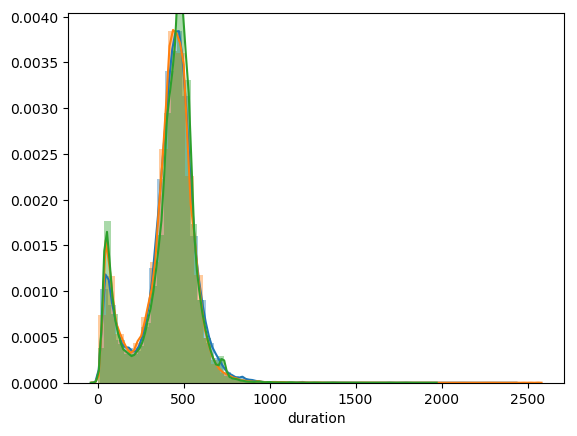

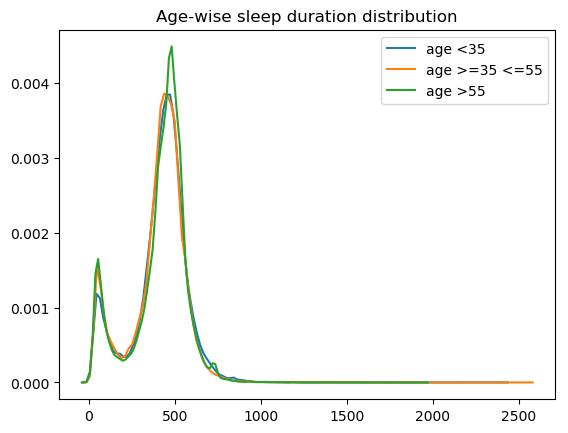

In [178]:
plt.figure()
ax1 = sns.distplot(sleepDf_[sleepDf_['age']<age1]['duration'],label = 'age <35')
data_x1, data_y1 = ax1.lines[0].get_data()
ax2 = sns.distplot(sleepDf_[np.logical_and(sleepDf_['age']>=age1,sleepDf_['age']<=age2)]['duration'],label = 'age >=35 <=55')
data_x2, data_y2 = ax2.lines[1].get_data()
ax3 = sns.distplot(sleepDf_[sleepDf_['age']>age2]['duration'],label = 'age <55')
data_x3, data_y3 = ax3.lines[2].get_data()
plt.show()

plt.figure()
plt.plot(data_x1,data_y1,label = 'age <35')
plt.plot(data_x2,data_y2,label = 'age >=35 <=55')
plt.plot(data_x3,data_y3,label = 'age >55')
plt.legend()
plt.title('Age-wise sleep duration distribution')
plt.show()


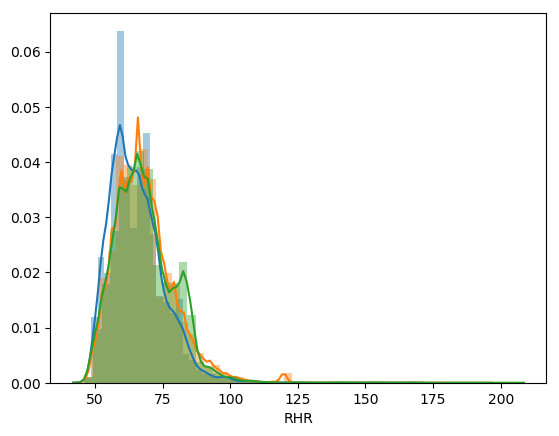

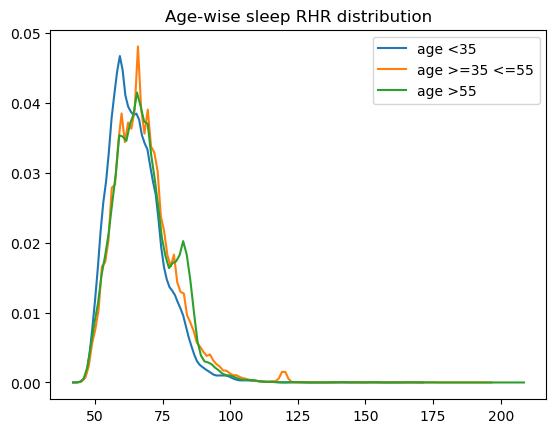

In [180]:
plt.figure()
ax1 = sns.distplot(sleepDf_[sleepDf_['age']<age1]['RHR'].dropna(),label = 'age <35')
data_x1, data_y1 = ax1.lines[0].get_data()
ax2 = sns.distplot(sleepDf_[np.logical_and(sleepDf_['age']>=age1,sleepDf_['age']<=age2)]['RHR'].dropna(),label = 'age >=35 <=55')
data_x2, data_y2 = ax2.lines[1].get_data()
ax3 = sns.distplot(sleepDf_[sleepDf_['age']>age2]['RHR'].dropna(),label = 'age <55')
data_x3, data_y3 = ax3.lines[2].get_data()
plt.show()

plt.figure()
plt.plot(data_x1,data_y1,label = 'age <35')
plt.plot(data_x2,data_y2,label = 'age >=35 <=55')
plt.plot(data_x3,data_y3,label = 'age >55')
plt.legend()
plt.title('Age-wise sleep RHR distribution')
plt.show()


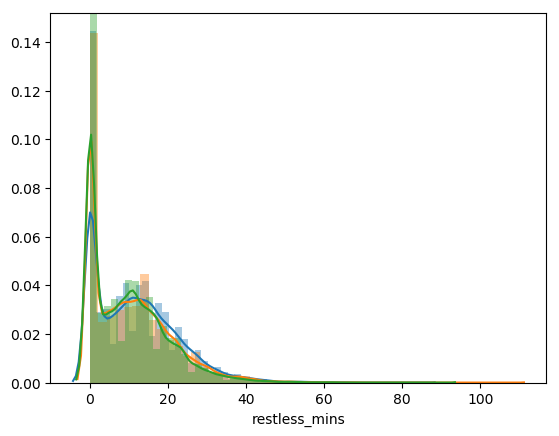

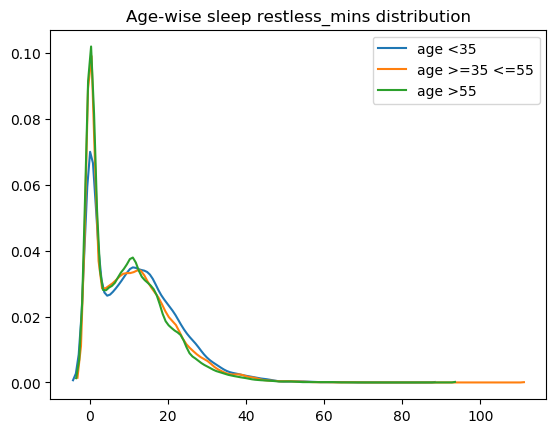

In [181]:
plt.figure()
ax1 = sns.distplot(sleepDf_[sleepDf_['age']<age1]['restless_mins'].dropna(),label = 'age <35')
data_x1, data_y1 = ax1.lines[0].get_data()
ax2 = sns.distplot(sleepDf_[np.logical_and(sleepDf_['age']>=age1,sleepDf_['age']<=age2)]['restless_mins'].dropna(),label = 'age >=35 <=55')
data_x2, data_y2 = ax2.lines[1].get_data()
ax3 = sns.distplot(sleepDf_[sleepDf_['age']>age2]['restless_mins'].dropna(),label = 'age <55')
data_x3, data_y3 = ax3.lines[2].get_data()
plt.show()

plt.figure()
plt.plot(data_x1,data_y1,label = 'age <35')
plt.plot(data_x2,data_y2,label = 'age >=35 <=55')
plt.plot(data_x3,data_y3,label = 'age >55')
plt.legend()
plt.title('Age-wise sleep restless_mins distribution')
plt.show()
